<a href="https://colab.research.google.com/github/sagihaider/EEG_Deep/blob/master/main_Single_Trial_Classification_PatientData_Binary_NSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sagihaider/EEG_Deep.git

Cloning into 'EEG_Deep'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 207 (delta 28), reused 13 (delta 5), pack-reused 153
Receiving objects: 100% (207/207), 858.77 MiB | 38.70 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Checking out files: 100% (60/60), done.


In [33]:
import scipy.io as spio
import numpy as np
from importlib.machinery import SourceFileLoader

# EEGNet-specific imports
from EEG_Deep.EEGModels import EEGNet, ShallowConvNet, DeepConvNet, EEGNet_Patient
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter

!pip install neural_structured_learning
import tensorflow as tf
import neural_structured_learning as nsl

In [0]:
# Band-pass Filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y


EEG_Deep/Data2A/parsed_P01T.mat
Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P01E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[2 1 1 2 2 2 1 2 2 1 2 2 2 1 2 2 1 1 1 1]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 5ms/sample - loss: 1.4656 - acc: 0.2333 - val_loss: 1.3892 - val_acc: 0.2000
Epoch 2/500
60/60 [==============================] - 0s 704us/sample - loss: 1.2502 - acc: 0.58

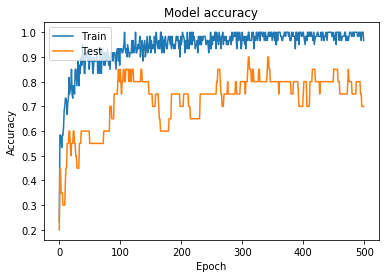


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 0.5952 - acc: 0.7500
test loss, test acc: [0.595165408635512, 0.75]



EEG_Deep/Data2A/parsed_P02T.mat


Using TensorFlow backend.


Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P02E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[2 1 1 2 1 2 1 2 1 1 1 1 1 2 2 2 1 2 2 1]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 6ms/sample - loss: 1.5283 - acc: 0.2667 - val_loss: 1.3692 - val_acc: 0.5500
Epoch 2/500
60/60 [==============================] - 0s 683us/sample - loss: 1.2480 - acc: 0.5667 - val_loss: 1.3710 - val_acc:

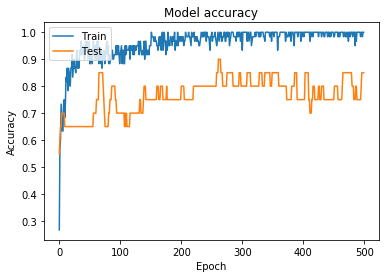


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 0.7159 - acc: 0.6750
test loss, test acc: [0.7158908195182448, 0.675]
EEG_Deep/Data2A/parsed_P03T.mat
Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P03E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[1 1 2 1 2 1 2 1 1 1 2 1 2 2 1 2 1 1 1 1]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 5ms/sample - l

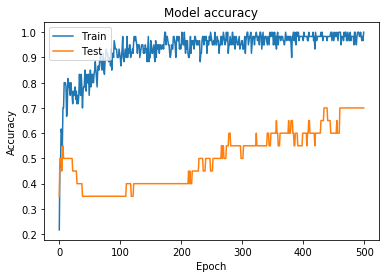


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 0.9026 - acc: 0.6000
test loss, test acc: [0.9025908949319273, 0.6]
EEG_Deep/Data2A/parsed_P04T.mat
Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P04E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[1 2 2 2 1 1 1 2 2 2 1 1 2 2 2 1 1 1 2 2]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 5ms/sample - los

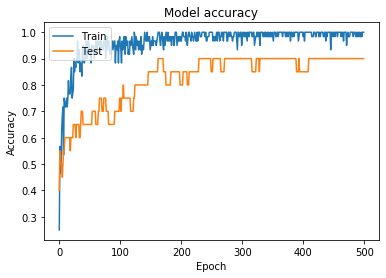


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 0.4817 - acc: 0.7750
test loss, test acc: [0.4816613879636861, 0.775]
EEG_Deep/Data2A/parsed_P05T.mat
Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P05E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[1 2 2 1 2 1 1 2 2 1 1 1 1 1 2 2 2 2 1 2]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 5ms/sample - l

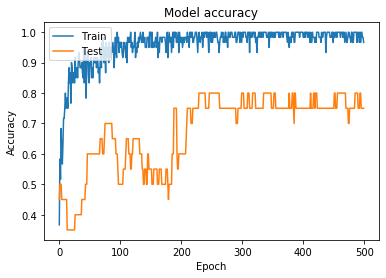


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 0.7391 - acc: 0.6500
test loss, test acc: [0.7391264736170114, 0.65]
EEG_Deep/Data2A/parsed_P06T.mat
Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P06E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[2 1 2 2 2 2 1 1 2 1 2 2 1 2 2 1 1 2 2 1]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 5ms/sample - lo

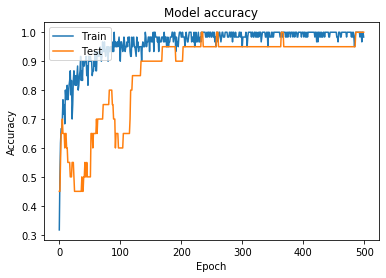


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 0.7722 - acc: 0.7500
test loss, test acc: [0.7722064129018691, 0.75]
EEG_Deep/Data2A/parsed_P07T.mat
Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P07E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 5ms/sample - lo

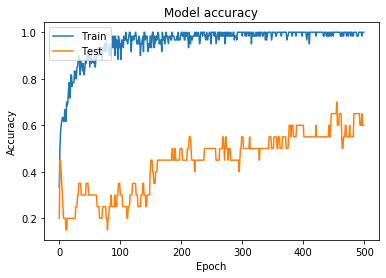


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 0.4744 - acc: 0.7500
test loss, test acc: [0.47436710058245807, 0.75]
EEG_Deep/Data2A/parsed_P08T.mat
Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P08E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[1 2 2 2 1 2 2 2 1 2 1 1 1 1 1 1 2 2 2 1]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 5ms/sample - l

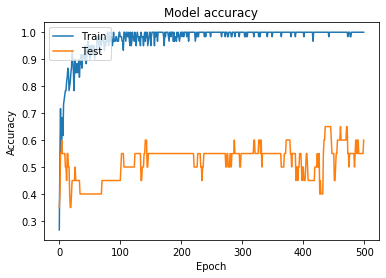


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 1.3609 - acc: 0.4000
test loss, test acc: [1.360870299115777, 0.4]
EEG_Deep/Data2A/parsed_P09T.mat
Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P09E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[2 1 1 1 1 2 2 1 1 1 1 2 2 2 2 2 2 2 1 1]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 6ms/sample - loss

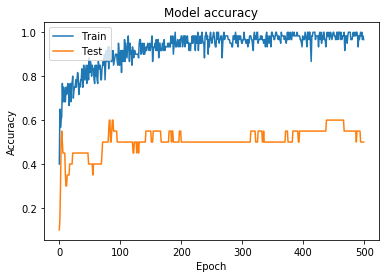


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 1.3705 - acc: 0.5500
test loss, test acc: [1.3704636931652203, 0.55]
EEG_Deep/Data2A/parsed_P010T.mat
Filtering of Training Data Finished
EEG_Deep/Data2A/parsed_P010E.mat
Filtering of Testing Data Finished
(1, 2)
Finding labels in training data
Finding labels in testing data
[1 1 2 1 1 1 2 2 2 1 1 1 1 2 2 2 2 1 1 1]
(60, 12, 1536)
(60,)
(20, 12, 1536)
(20,)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
X_train shape: (60, 1, 12, 1536)
60 train samples
20 val samples
(40, 12, 1536)
(40, 1)
X_train shape: (40, 1, 12, 1536)
40 train samples
Train on 60 samples, validate on 20 samples
Epoch 1/500
60/60 [==============================] - 0s 5ms/sample - 

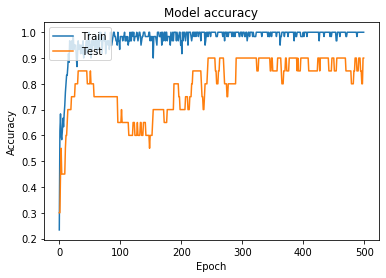


# Evaluate on test data
40/40 [==============================] - 0s 2ms/sample - loss: 0.4057 - acc: 0.8750
test loss, test acc: [0.40566048201580995, 0.875]
[[0.59516541]
 [0.71589082]
 [0.90259089]
 [0.48166139]
 [0.73912647]
 [0.77220641]
 [0.4743671 ]
 [1.3608703 ]
 [1.37046369]
 [0.40566048]]
[[0.75      ]
 [0.67500001]
 [0.60000002]
 [0.77499998]
 [0.64999998]
 [0.75      ]
 [0.75      ]
 [0.40000001]
 [0.55000001]
 [0.875     ]]


<Figure size 432x288 with 0 Axes>

In [35]:
from numpy import zeros
K.clear_session()
cols = 1
rows = 10
acc_all = zeros([rows, cols])
loss_all = zeros([rows, cols])
X_tr_c12 = np.empty([80, 12, 4096])
X_ts_c12 = np.empty([80, 12, 4096])
result=[]

from itertools import combinations 
comb = combinations([1, 2], 2) 
  # Print the obtained combinations 
bincomb=[]
for i in list(comb): 
    bincomb.append(i)

for x in range(1,11):
  fName = 'EEG_Deep/Data2A/parsed_P0' + str(x) + 'T.mat'  # Load Data
  print(fName)
  mat = spio.loadmat(fName)
  r_X_tr = mat['RawEEGData']
  r_y_tr = mat['Labels']

  ### Filter Data ###
  for t in range(r_X_tr.shape[0]):
    tril = r_X_tr[t,:,:]
    # tril = tril.transpose()
    tril_filtered = butter_bandpass_filter(tril, 
                                              lowcut=8, 
                                              highcut=24, 
                                              fs=512,
                                              order=4)
    # tril_filtered = tril_filtered.transpose()
    X_tr_c12[t,:,:] = tril_filtered

  print("Filtering of Training Data Finished")
  ## Test Data Load 

  fName = 'EEG_Deep/Data2A/parsed_P0' + str(x) + 'E.mat'  # Load Data
  print(fName)
  mat = spio.loadmat(fName)
  r_X_ts = mat['RawEEGData']
  r_y_ts = mat['Labels']
  for t in range(r_X_ts.shape[0]):
    tril = r_X_ts[t,:,:]
    # tril = tril.transpose()
    tril_filtered = butter_bandpass_filter(tril, 
                                              lowcut=8, 
                                              highcut=24, 
                                              fs=512,
                                              order=4)
    # tril_filtered = tril_filtered.transpose()
    X_ts_c12[t,:,:] = tril_filtered
  
  print("Filtering of Testing Data Finished")    

  for k, com in enumerate(bincomb):
      print(com)
      # # Find labels to specific class
      print("Finding labels in training data")
      class1indx = list(np.where(r_y_tr == com[0]))
      class2indx = list(np.where(r_y_tr == com[1]))
      c1=list(class1indx[0])
      c2=list(class2indx[0])
      y_tr_c12 = c1 + c2
      y_tr_c12.sort()
      # print(y_tr_c12)
      x_tr_12 = X_tr_c12[y_tr_c12,:,:]
      y_tr_12 = r_y_tr[y_tr_c12]
      # print(np.shape(x_tr_12))
      # print(np.shape(y_tr_12))
      # # Find labels to specific class
      print("Finding labels in testing data")
      class1indx = list(np.where(r_y_ts == com[0]))
      class2indx = list(np.where(r_y_ts == com[1]))
      c1=list(class1indx[0])
      c2=list(class2indx[0])
      y_ts_c12 = c1 + c2
      y_ts_c12.sort()
      # print(y_ts_c12)
      x_ts_12 = X_ts_c12[y_ts_c12,:,:]
      y_ts_12 = r_y_ts[y_ts_c12]
      # print(np.shape(x_ts_12))
      # print(np.shape(y_ts_12))
      del class1indx, class2indx, c1, c2

      # shuffle the training data
      indices = np.arange(x_tr_12.shape[0])
      np.random.shuffle(indices)
      x_tr_12 = x_tr_12[indices]
      y_tr_12 = y_tr_12[indices]

      # split data of each subject in training and validation
      X_train = x_tr_12[0:60,:,2560:4096]
      Y_train = y_tr_12[0:60].ravel()
      X_val   = x_tr_12[60:,:,2560:4096]
      Y_val   = y_tr_12[60:].ravel()
      print(Y_val)
      print(np.shape(X_train))
      print(np.shape(Y_train))
      print(np.shape(X_val))
      print(np.shape(Y_val))
  
      # convert labels to one-hot encodings.
      Y_train      = np_utils.to_categorical(Y_train-1, num_classes=4)
      Y_val       = np_utils.to_categorical(Y_val-1, num_classes=4)
      print(Y_val)

      kernels, chans, samples = 1, 12, 1536
      # convert data to NCHW (trials, kernels, channels, samples) format. Data 
      # contains 22 channels and 500 time-points. Set the number of kernels to 1.
      X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
      X_val   = X_val.reshape(X_val.shape[0], kernels, chans, samples)
   
      print('X_train shape:', X_train.shape)
      print(X_train.shape[0], 'train samples')
      print(X_val.shape[0], 'val samples')

      X_test      = x_ts_12[:,:,2560:4096]
      Y_test      = y_ts_12[:]
      print(np.shape(X_test))
      print(np.shape(Y_test))

      #convert labels to one-hot encodings.
      Y_test      = np_utils.to_categorical(Y_test-1, num_classes=4)

      # convert data to NCHW (trials, kernels, channels, samples) format. Data 
      # contains 22 channels and 500 time-points. Set the number of kernels to 1.
      X_test      = X_test.reshape(X_test.shape[0], kernels, chans, samples)

      print('X_train shape:', X_test.shape)
      print(X_test.shape[0], 'train samples')


      ##### Learning without NSL ###########################################
      
      # # Create a base model -- sequential, functional, or subclass.
      # model = tf.keras.Sequential([
      #                              tf.keras.Input((1, 12, 1536), name='feature'),
      #                              tf.keras.layers.Flatten(),
      #                              tf.keras.layers.Dense(64, activation=tf.nn.relu),
      #                              tf.keras.layers.Dense(2, activation=tf.nn.softmax)
      #                              ])
      # model.summary()
      
      # # Compile, train, and evaluate.
      # model.compile(optimizer='adam',
      #                   loss='categorical_crossentropy',
      #                   metrics=['accuracy'])
      
      # history = model.fit(X_train, Y_train, batch_size = 32, epochs = 500, 
      #                     verbose = 2, validation_data=(X_val, Y_val)
      #                     )

      # configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
      # model configurations may do better, but this is a good starting point)

      ##### Learning without NSL ################################################
    #   model = EEGNet(nb_classes = 4, Chans = 12, Samples = 1536,
    #                  dropoutRate = 0.5, kernLength = 25, F1 = 8, 
    #                  D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')

    #  # Compile, train, and evaluate.
    #   model.compile(optimizer='adam',
    #                     loss='categorical_crossentropy',
    #                     metrics=['accuracy'])
      
    #   history = model.fit(X_train, Y_train, batch_size = 32, epochs = 500, 
    #                           validation_data=(X_val, Y_val)
    #                           )


      ##### Learning with NSL ################################################
      # Wrap the model with adversarial regularization.

      model = EEGNet(nb_classes = 4, Chans = 12, Samples = 1536,
                     dropoutRate = 0.5, kernLength = 25, F1 = 8,
                     D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')
            
      adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
      adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)
      
      # Compile, train, and evaluate.
      model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
      
      history = model.fit(X_train, Y_train, batch_size = 32,
                          epochs = 500,
                          validation_data=(X_val, Y_val)
                          )
      

      ##### Plot with NSL ################################################

      # Plot training & validation accuracy values
      plt.plot(history.history['acc'])
      plt.plot(history.history['val_acc'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()
      figName = 'Accuracy_A0' + str(x) + '.png'  
      plt.savefig(figName)

      print('\n# Evaluate on test data')
      results = model.evaluate(X_test, Y_test, batch_size=1)
      print('test loss, test acc:', results)

      loss_all[x - 1, k-1] = results[0]
      acc_all[x - 1, k-1] = results[1]

      from keras import backend as K 
      # Do some code, e.g. train and save model
      K.clear_session()

print(loss_all)
print(acc_all)   

     


In [0]:
import pandas as pd
df_accl_all = pd.DataFrame({'Class1vs2': acc_all[:, 0]})
df_accl_all.to_csv (r'EEG_Deep/df_accl_allPatient_8_24_2560:4096.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path
